WeatherPy

In [1]:
# Dependencies and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import json
from scipy import stats
from scipy.stats import linregress

# Import API key
from api_keys import weather_api

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90,90)
lng_range = (-180, 180)

Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat an lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=25)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=25)
lat_lngs = zip(lats,lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name

    # If the city is unique, then add it to a cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

21

Perform API Calls

In [3]:
# Save url configuration
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# See API layout
test_query = f"{url}q={city}&appid={weather_api}&units={units}"
test_response = requests.get(test_query)
test_json_response = test_response.json()
print(json.dumps(test_json_response, indent=4))

{
    "coord": {
        "lon": 68.795,
        "lat": 42.4252
    },
    "weather": [
        {
            "id": 800,
            "main": "Clear",
            "description": "clear sky",
            "icon": "01d"
        }
    ],
    "base": "stations",
    "main": {
        "temp": 88.02,
        "feels_like": 84.25,
        "temp_min": 88.02,
        "temp_max": 88.02,
        "pressure": 1007,
        "humidity": 13,
        "sea_level": 1007,
        "grnd_level": 981
    },
    "visibility": 10000,
    "wind": {
        "speed": 10.78,
        "deg": 14,
        "gust": 10.6
    },
    "clouds": {
        "all": 2
    },
    "dt": 1624690043,
    "sys": {
        "type": 1,
        "id": 8824,
        "country": "KZ",
        "sunrise": 1624664952,
        "sunset": 1624719955
    },
    "timezone": 21600,
    "id": 1526168,
    "name": "Arys",
    "cod": 200
}


In [4]:
# Set empty lists to hold Temperature, Humidity, Cloudiness, Wind Speed, & Latitude
name = []
lat = []
lng = []
temp = []
humid = []
cloud = []
wind = []
country = []
date = []




# Create starting point for record count
record_count = 0

# Print beginning text
print(f"Beginning Data Retrieval")
print(f"-------------------------")


# Loop through each city
for city in cities:

    # Create search query, make reqeust and store in json
    query_url = f"{url}q={city}&appid={weather_api}&units={units}"
    response = requests.get(query_url)
    json_response = response.json()
    record_count = record_count + 1

    # Try to grab data if available in API
    try:
        name.append(json_response["name"])
        lat.append(json_response["coord"]["lat"])               
        lng.append(json_response["coord"]["lon"])               
        temp.append(json_response["main"]["temp_max"])
        humid.append(json_response["main"]["humidity"])
        cloud.append(json_response["clouds"]["all"])
        wind.append(json_response["wind"]["speed"])
        country.append(json_response["sys"]["country"])
        date.append(json_response["dt"])
        
        print(f"Processing Record {record_count}: {name}")
    
        

    # Handle exceptions for a city that is not available in SPI
    except:
        # Append null values
        print("City not found. Skipping...")
        pass

print(f"-------------------------")
print(f"Data Retrieval Complete")
print(f"-------------------------")

Beginning Data Retrieval
-------------------------
Processing Record 1: ['Lithgow']
Processing Record 2: ['Lithgow', 'Mataura']
Processing Record 3: ['Lithgow', 'Mataura', 'Hilo']
Processing Record 4: ['Lithgow', 'Mataura', 'Hilo', 'Tasiilaq']
Processing Record 5: ['Lithgow', 'Mataura', 'Hilo', 'Tasiilaq', 'Hobart']
Processing Record 6: ['Lithgow', 'Mataura', 'Hilo', 'Tasiilaq', 'Hobart', 'Rikitea']
Processing Record 7: ['Lithgow', 'Mataura', 'Hilo', 'Tasiilaq', 'Hobart', 'Rikitea', 'Ancud']
City not found. Skipping...
Processing Record 9: ['Lithgow', 'Mataura', 'Hilo', 'Tasiilaq', 'Hobart', 'Rikitea', 'Ancud', 'Pangnirtung']
Processing Record 10: ['Lithgow', 'Mataura', 'Hilo', 'Tasiilaq', 'Hobart', 'Rikitea', 'Ancud', 'Pangnirtung', 'Longyearbyen']
Processing Record 11: ['Lithgow', 'Mataura', 'Hilo', 'Tasiilaq', 'Hobart', 'Rikitea', 'Ancud', 'Pangnirtung', 'Longyearbyen', 'Ushuaia']
Processing Record 12: ['Lithgow', 'Mataura', 'Hilo', 'Tasiilaq', 'Hobart', 'Rikitea', 'Ancud', 'Pangnir

Convert Raw Data to DataFrame

In [5]:
# Create new dataframe 
cities_df = pd.DataFrame({"City": name, "Latitude": lat, "Longitude": lng, "Max Temperature": temp, "Humidity": humid, "Cloudiness": cloud, "Wind Speed": wind, "Country": country, "Date": date})
cities_df.to_csv("output_data/cities.csv")

# Convert date column from unix
cities_df["Date"] = pd.to_datetime(cities_df["Date"], unit="s", origin="unix")

# Prview new dataframe
cities_df.head()

,City,Latitude,Longitude,Max Temperature,Humidity,Cloudiness,Wind Speed,Country,Date
0,Lithgow,-33.4833,150.1500,48.51,75,81,10.83,AU,2021-06-26 06:47:24
1,Mataura,-46.1927,168.8643,50.49,96,100,1.23,NZ,2021-06-26 06:47:25
2,Hilo,19.7297,-155.0900,78.28,85,90,4.61,US,2021-06-26 06:47:25
3,Tasiilaq,65.6145,-37.6368,53.76,59,16,9.13,GL,2021-06-26 06:47:26
4,Hobart,-42.8794,147.3294,52.92,66,75,1.99,AU,2021-06-26 06:43:01


In [6]:
# Describe new dataframe to see if there are any cities with humidity greater than 100%
cities_df.describe()

,Latitude,Longitude,Max Temperature,Humidity,Cloudiness,Wind Speed
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,1.521465,0.608265,60.958824,71.588235,59.941176,6.874118
std,44.191585,101.181642,17.258015,19.532213,37.313655,4.416069
min,-54.800000,-155.090000,38.840000,13.000000,2.000000,1.230000
25%,-33.925800,-68.300000,48.510000,65.000000,16.000000,3.600000
50%,-14.473900,-37.636800,58.870000,75.000000,75.000000,5.010000
75%,41.371200,68.795000,74.430000,83.000000,84.000000,10.780000
max,78.218600,168.864300,90.180000,96.000000,100.000000,17.270000


In [7]:
# Confirm there are no rows with humdity greater than 100%
cities_df.loc[cities_df["Humidity"]>100]

,City,Latitude,Longitude,Max Temperature,Humidity,Cloudiness,Wind Speed,Country,Date


Plotting the Data

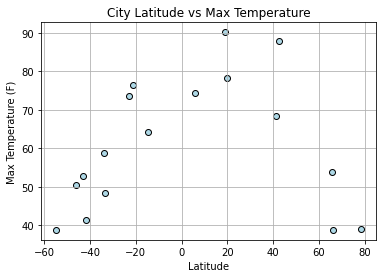

This plot shows the correlation between a cities latitide and its max temperature.


In [8]:
# Create plot for Latitude vs Temperature
plt.title("City Latitude vs Max Temperature")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.scatter(cities_df["Latitude"], cities_df["Max Temperature"], marker="o", facecolors="lightblue", edgecolors="black")
plt.grid()
plt.show()
print("This plot shows the correlation between a cities latitide and its max temperature.")

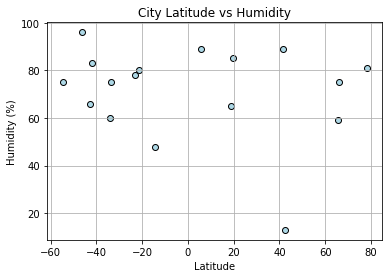

This plot shows the correlation between a cities latitide and its humidity.


In [9]:
# Create plot for Latitude vs Humidity
plt.title("City Latitude vs Humidity")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.scatter(cities_df["Latitude"], cities_df["Humidity"], marker="o", facecolors="lightblue", edgecolors="black")
plt.grid()
plt.show()
print("This plot shows the correlation between a cities latitide and its humidity.")

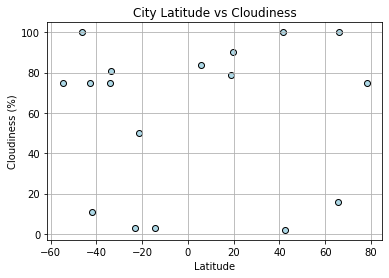

This plot shows the correlation between a cities latitide and its cloudiness.


In [10]:
# Create plot for Latitude vs Cloudiness
plt.title("City Latitude vs Cloudiness")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.scatter(cities_df["Latitude"], cities_df["Cloudiness"], marker="o", facecolors="lightblue", edgecolors="black")
plt.grid()
plt.show()
print("This plot shows the correlation between a cities latitide and its cloudiness.")

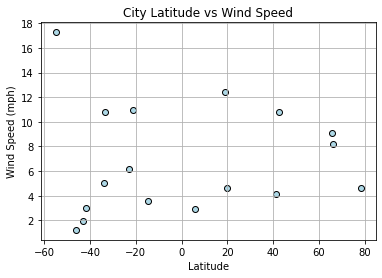

This plot shows the correlation between a cities latitide and its wind speed.


In [11]:
# Create plot for Latitude vs Wind Speed
plt.title("City Latitude vs Wind Speed")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.scatter(cities_df["Latitude"], cities_df["Wind Speed"], marker="o", facecolors="lightblue", edgecolors="black")
plt.grid()
plt.show()
print("This plot shows the correlation between a cities latitide and its wind speed.")

Linear Regression by Hemisphere

In [12]:
# Create new dataframes for North and South hemispheres
north_df = cities_df[cities_df["Latitude"]>=0]
south_df = cities_df[cities_df["Latitude"]<0]

The r-value is: -0.8167523002214795


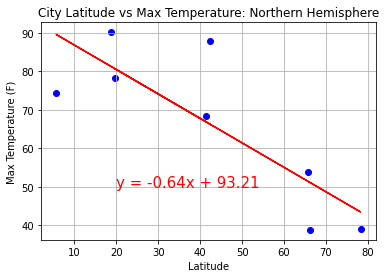

This plot shows the correlation between a cities latitide and its max temperature.


In [13]:
# Create plot for Latitude vs Temperature for NORTHERN HEMISPHERE
x_values = north_df["Latitude"]
y_values = north_df["Max Temperature"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.title("City Latitude vs Max Temperature: Northern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.scatter(north_df["Latitude"], north_df["Max Temperature"], marker="o", facecolors="blue", edgecolors="blue")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,50),fontsize=15,color="red")
plt.grid()
print(f"The r-value is: {rvalue}")
plt.show()
print("This plot shows the correlation between a cities latitide and its max temperature.")

The r-value is: 0.8423917298990199


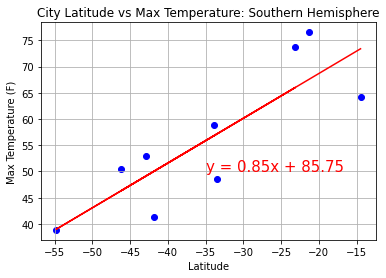

This plot shows the correlation between a cities latitide and its max temperature.


In [22]:
# Create plot for Latitude vs Temperature for SOUTHERN HEMISPHERE
x_values = south_df["Latitude"]
y_values = south_df["Max Temperature"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.title("City Latitude vs Max Temperature: Southern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.scatter(south_df["Latitude"], south_df["Max Temperature"], marker="o", facecolors="blue", edgecolors="blue")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-35,50),fontsize=15,color="red")
plt.grid()
print(f"The r-value is: {rvalue}")
plt.show()
print("This plot shows the correlation between a cities latitide and its max temperature.")

The r-value is: -0.14735354718902963


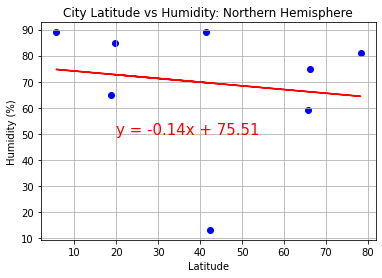

This plot shows the correlation between a cities latitide and its max temperature.


In [15]:
# Create plot for Latitude vs Humidity for NORTHERN HEMISPHERE
x_values = north_df["Latitude"]
y_values = north_df["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.title("City Latitude vs Humidity: Northern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.scatter(north_df["Latitude"], north_df["Humidity"], marker="o", facecolors="blue", edgecolors="blue")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,50),fontsize=15,color="red")
plt.grid()
print(f"The r-value is: {rvalue}")
plt.show()
print("This plot shows the correlation between a cities latitide and its max temperature.")

The r-value is: -0.46573104326815923


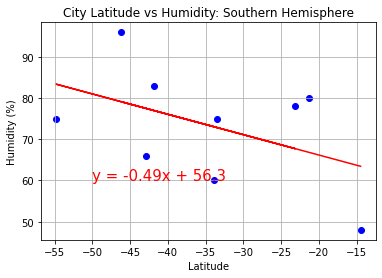

This plot shows the correlation between a cities latitide and its max temperature.


In [23]:
# Create plot for Latitude vs Humidity for SOUTHERN HEMISPHERE
x_values = south_df["Latitude"]
y_values = south_df["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.title("City Latitude vs Humidity: Southern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.scatter(south_df["Latitude"], south_df["Humidity"], marker="o", facecolors="blue", edgecolors="blue")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,60),fontsize=15,color="red")
plt.grid()
print(f"The r-value is: {rvalue}")
plt.show()
print("This plot shows the correlation between a cities latitide and its max temperature.")

The r-value is: -0.22725235538520727


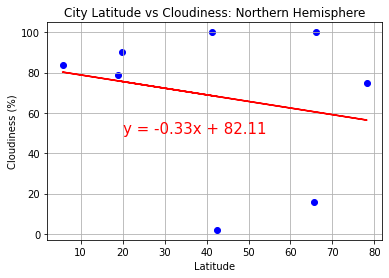

This plot shows the correlation between a cities latitide and its max temperature.


In [17]:
# Create plot for Latitude vs Cloudiness for NORTHERN HEMISPHERE
x_values = north_df["Latitude"]
y_values = north_df["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.title("City Latitude vs Cloudiness: Northern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.scatter(north_df["Latitude"], north_df["Cloudiness"], marker="o", facecolors="blue", edgecolors="blue")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,50),fontsize=15,color="red")
plt.grid()
print(f"The r-value is: {rvalue}")
plt.show()
print("This plot shows the correlation between a cities latitide and its max temperature.")

The r-value is: -0.6207979975530399


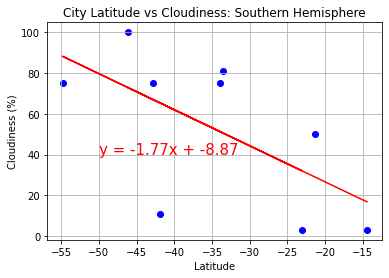

This plot shows the correlation between a cities latitide and its max temperature.


In [24]:
# Create plot for Latitude vs Cloudiness for SOUTHERN HEMISPHERE
x_values = south_df["Latitude"]
y_values = south_df["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.title("City Latitude vs Cloudiness: Southern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.scatter(south_df["Latitude"], south_df["Cloudiness"], marker="o", facecolors="blue", edgecolors="blue")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,40),fontsize=15,color="red")
plt.grid()
print(f"The r-value is: {rvalue}")
plt.show()
print("This plot shows the correlation between a cities latitide and its max temperature.")

The r-value is: 0.11112364327091388


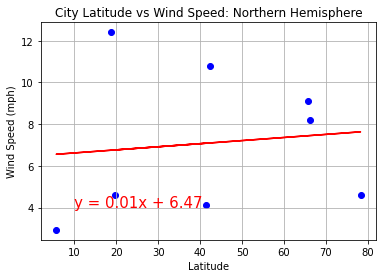

This plot shows the correlation between a cities latitide and its max temperature.


In [25]:
# Create plot for Latitude vs Wind Speed for NORTHERN HEMISPHERE
x_values = north_df["Latitude"]
y_values = north_df["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.title("City Latitude vs Wind Speed: Northern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.scatter(north_df["Latitude"], north_df["Wind Speed"], marker="o", facecolors="blue", edgecolors="blue")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(10,4),fontsize=15,color="red")
plt.grid()
print(f"The r-value is: {rvalue}")
plt.show()
print("This plot shows the correlation between a cities latitide and its max temperature.")

The r-value is: -0.16641195924058502


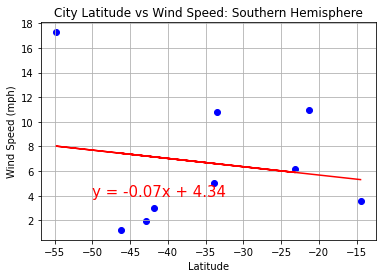

This plot shows the correlation between a cities latitide and its max temperature.


In [26]:
# Create plot for Latitude vs Wind Speed for SOUTHERN HEMISPHERE
x_values = south_df["Latitude"]
y_values = south_df["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.title("City Latitude vs Wind Speed: Southern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.scatter(south_df["Latitude"], south_df["Wind Speed"], marker="o", facecolors="blue", edgecolors="blue")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,4),fontsize=15,color="red")
plt.grid()
print(f"The r-value is: {rvalue}")
plt.show()
print("This plot shows the correlation between a cities latitide and its max temperature.")